In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys

# Add your absolute path of your project folder to system path.
sys.path.append("/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/train")
sys.path.append("/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/test")
sys.path.append("/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/validation")

# See the full list of paths in sys.path
print(sys.path)

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/train', '/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/test', '/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/validation']


In [ ]:
!nvidia-smi

Sun Apr 14 19:00:41 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import random
import numpy as np
import os
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt

import torch
import torchvision
from torchvision import transforms
from torch import nn
from torchvision import transforms

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader,WeightedRandomSampler

NUM_WORKERS = os.cpu_count()
NUM_WORKERS

2

In [ ]:
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# Setup directory paths to train and test images
train_dir = "/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/train"
test_dir = "/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/test"
val_dir = "/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/validation"

In [ ]:
#Loading pre-trained weights of Vision Transformer model

pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

In [ ]:
#Setup a ViT model instance with pretrained weights

pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 139MB/s]


In [ ]:
#Freeze the base parameters

for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

In [ ]:
len(os.listdir(train_dir))

36

In [ ]:
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(os.listdir(train_dir))).to(device)

In [ ]:
!pip install torchinfo

In [ ]:
import torchinfo
from torchinfo import summary


# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(128, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size"], # uncomment for smaller output
        #col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape
VisionTransformer (VisionTransformer)                        [128, 3, 224, 224]
├─Conv2d (conv_proj)                                         [128, 3, 224, 224]
├─Encoder (encoder)                                          [128, 197, 768]
│    └─Dropout (dropout)                                     [128, 197, 768]
│    └─Sequential (layers)                                   [128, 197, 768]
│    │    └─EncoderBlock (encoder_layer_0)                   [128, 197, 768]
│    │    └─EncoderBlock (encoder_layer_1)                   [128, 197, 768]
│    │    └─EncoderBlock (encoder_layer_2)                   [128, 197, 768]
│    │    └─EncoderBlock (encoder_layer_3)                   [128, 197, 768]
│    │    └─EncoderBlock (encoder_layer_4)                   [128, 197, 768]
│    │    └─EncoderBlock (encoder_layer_5)                   [128, 197, 768]
│    │    └─EncoderBlock (encoder_layer_6)                   [128, 197, 76

In [ ]:
from PIL import Image

In [ ]:
transform_custom = transforms.Compose([
    #transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Random horizontal flip
    transforms.RandomVerticalFlip(),    # Random vertical flip
    transforms.RandomRotation(degrees=40),  # Random rotation with a degree range of 30
    transforms.Resize((224, 224),interpolation=Image.BILINEAR),   # Resize the image
    #transforms.Grayscale(num_output_channels=3), # Convert to RGB if not already
    transforms.ToTensor(),           # Convert to PyTorch tensor
    transforms.Normalize(            # Normalize the tensor
        mean=[0.5, 0.5, 0.5],  # Using ImageNet mean and std
        std=[0.5, 0.5, 0.5]
    )
])

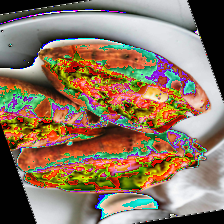

In [ ]:
img = Image.open("/content/drive/My Drive/Fruits_Vegetables_Data/DATA/Image_8.jpg")
out = transform_custom(img)

#image = transforms.ToPILImage(out)
#image.show()

to_pil = transforms.ToPILImage()
image = to_pil(out)

# Display the image (optional)
image

In [ ]:
def create_dataloaders(train_dir: str, test_dir: str, transform: transforms.Compose, batch_size: int, num_workers: int=NUM_WORKERS):

    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)
    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
          train_data,
          batch_size=batch_size,
          shuffle=True,
          num_workers=num_workers,
          pin_memory=True,
      )
    test_dataloader = DataLoader(
          test_data,
          batch_size=batch_size,
          shuffle=False,
          num_workers=num_workers,
          pin_memory=True,
      )

    return train_dataloader, test_dataloader, class_names

In [ ]:
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                    test_dir=test_dir,
                                                                                                     transform=transform_custom,
                                                                                                     batch_size=128)

In [ ]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.7f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [ ]:
# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=30,
                                      device=device)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.4010 | train_acc: 0.4818 | test_loss: 1.2533 | test_acc: 0.7816292
Epoch: 2 | train_loss: 1.1035 | train_acc: 0.7465 | test_loss: 0.6906 | test_acc: 0.8374292
Epoch: 3 | train_loss: 0.7714 | train_acc: 0.8050 | test_loss: 0.5573 | test_acc: 0.8556584
Epoch: 4 | train_loss: 0.6376 | train_acc: 0.8295 | test_loss: 0.4549 | test_acc: 0.8894367
Epoch: 5 | train_loss: 0.5807 | train_acc: 0.8365 | test_loss: 0.4171 | test_acc: 0.8752275
Epoch: 6 | train_loss: 0.5283 | train_acc: 0.8467 | test_loss: 0.3814 | test_acc: 0.9063258
Epoch: 7 | train_loss: 0.5032 | train_acc: 0.8577 | test_loss: 0.3515 | test_acc: 0.8868325
Epoch: 8 | train_loss: 0.4396 | train_acc: 0.8687 | test_loss: 0.3461 | test_acc: 0.9030896
Epoch: 9 | train_loss: 0.4055 | train_acc: 0.8862 | test_loss: 0.3087 | test_acc: 0.9096379
Epoch: 10 | train_loss: 0.3781 | train_acc: 0.8966 | test_loss: 0.3001 | test_acc: 0.9161104
Epoch: 11 | train_loss: 0.3595 | train_acc: 0.8991 | test_loss: 0.2994 | test_a

In [ ]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

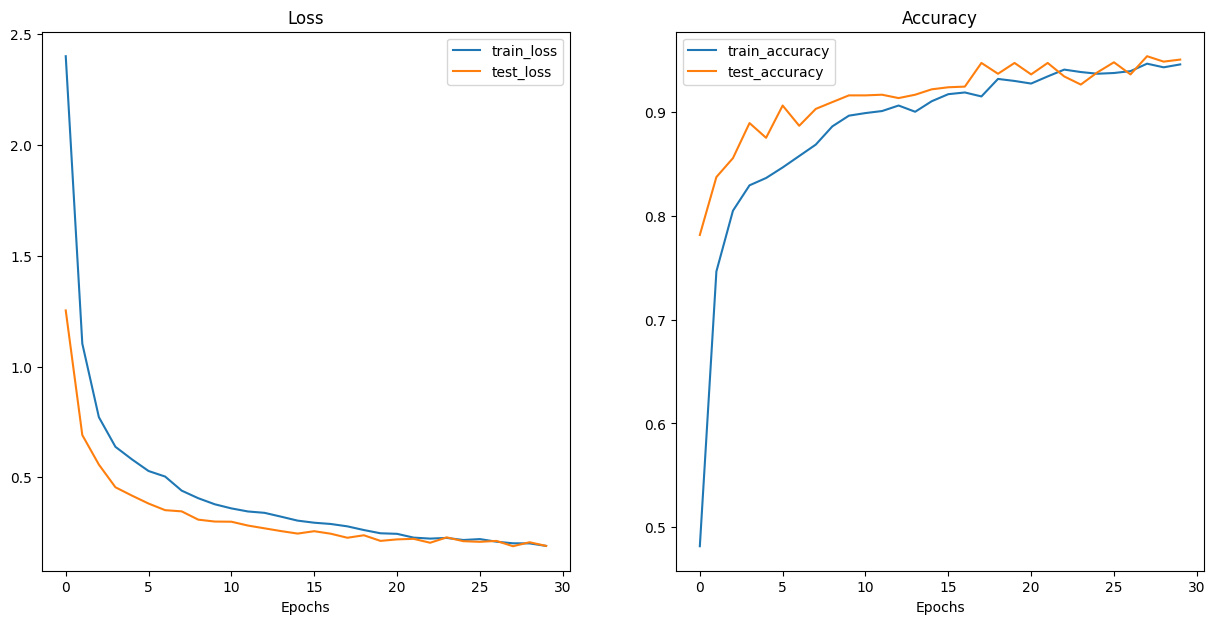

In [ ]:
# Plot the loss curves
#from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

In [ ]:
from PIL import Image

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Predict on a target image with a target model
# Function created in: https://www.learnpytorch.io/06_pytorch_transfer_learning/#6-make-predictions-on-images-from-the-test-set
def pred_and_plot_image(
    model: torch.nn.Module,
    class_names: List[str],
    image_path: str,
    image_size: Tuple[int, int] = (224, 224),
    transform: torchvision.transforms = None,
    device: torch.device = device,
):
    """Predicts on a target image with a target model.

    Args:
        model (torch.nn.Module): A trained (or untrained) PyTorch model to predict on an image.
        class_names (List[str]): A list of target classes to map predictions to.
        image_path (str): Filepath to target image to predict on.
        image_size (Tuple[int, int], optional): Size to transform target image to. Defaults to (224, 224).
        transform (torchvision.transforms, optional): Transform to perform on image. Defaults to None which uses ImageNet normalization.
        device (torch.device, optional): Target device to perform prediction on. Defaults to device.
    """

    # Open image
    img = Image.open(image_path)

    # Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose(
            [
                transforms.Resize(image_size),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )

    ### Predict on image ###

    # Make sure the model is on the target device
    model.to(device)

    # Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(
        f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    )
    plt.axis(False)

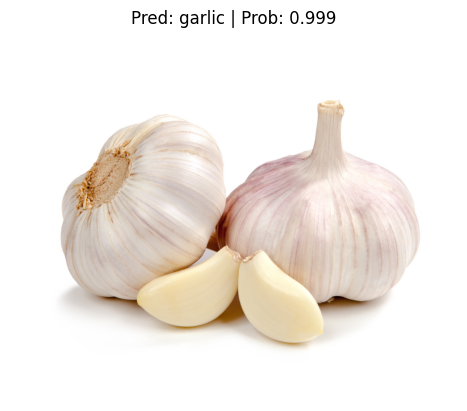

In [ ]:
import requests

# Import function to make predictions on images and plot them
#from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/DATA/Image_3.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

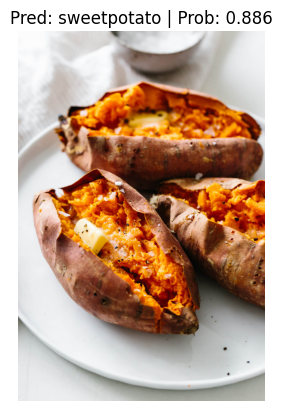

In [ ]:
# Import function to make predictions on images and plot them
# Setup custom image path
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/DATA/Image_8.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

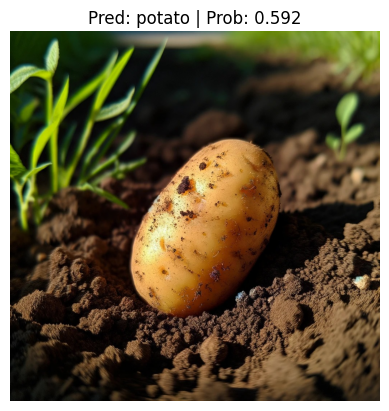

In [ ]:
# Import function to make predictions on images and plot them
# Setup custom image path
#custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/DATA/Image_8.jpg"
#####train_data = datasets.ImageFolder(train_dir)
#######class_names = train_data.classes
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test1.jpg"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
model_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Models/Model_Vit_Final2.pt"
model = pretrained_vit
torch.save(model,model_path)

In [ ]:
model_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Models/Model_Vit_Final2.pt"
model_loaded = torch.load(model_path)

In [ ]:
train_data = datasets.ImageFolder(train_dir)
class_names = train_data.classes

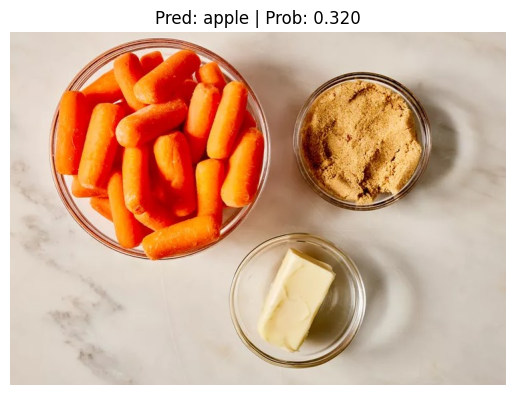

In [ ]:
# Import function to make predictions on images and plot them
# Setup custom image path
#custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/DATA/Image_8.jpg"
#####train_data = datasets.ImageFolder(train_dir)
#######class_names = train_data.classes
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test7_3.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

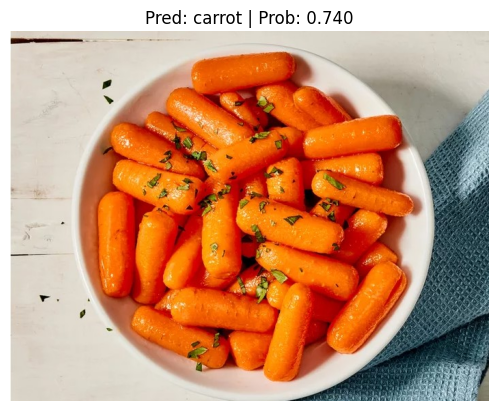

In [ ]:
# Import function to make predictions on images and plot them
# Setup custom image path
#custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/DATA/Image_8.jpg"
#####train_data = datasets.ImageFolder(train_dir)
#######class_names = train_data.classes
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test7_4.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

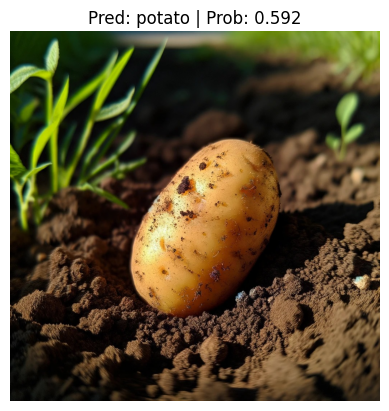

In [ ]:
# Import function to make predictions on images and plot them
# Setup custom image path
#custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/DATA/Image_8.jpg"
#####train_data = datasets.ImageFolder(train_dir)
#######class_names = train_data.classes
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test1.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

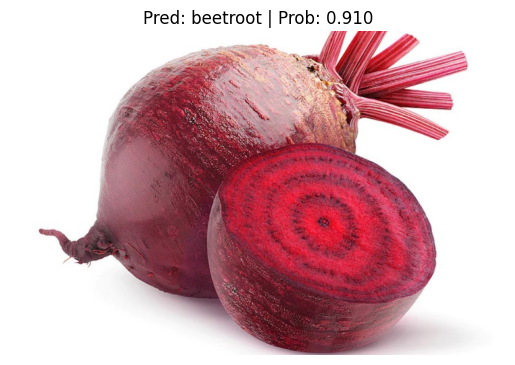

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test2.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

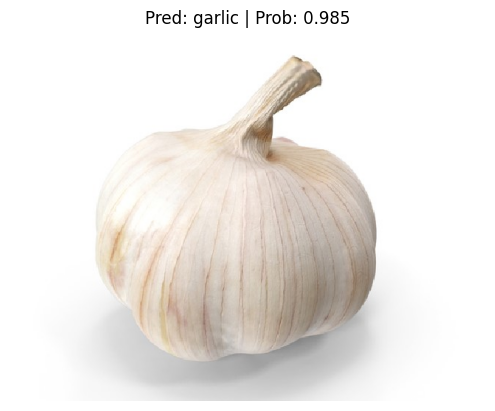

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test3.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

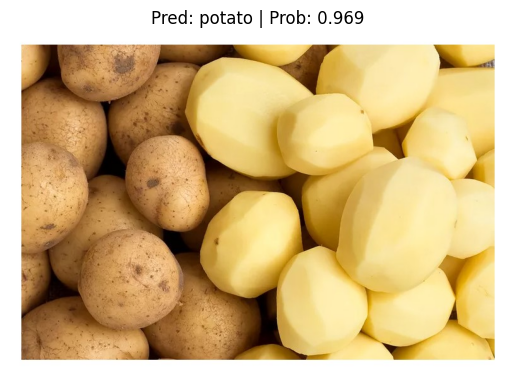

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test4_1.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

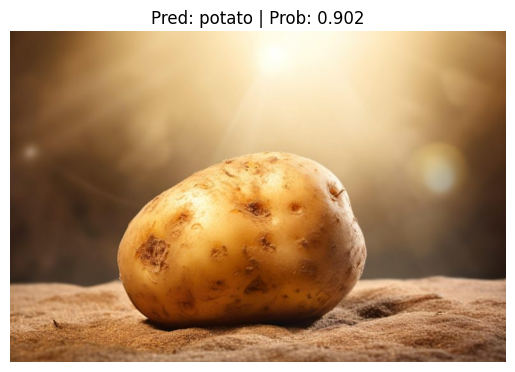

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test4_3.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

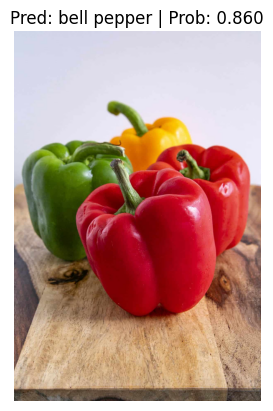

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test5.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

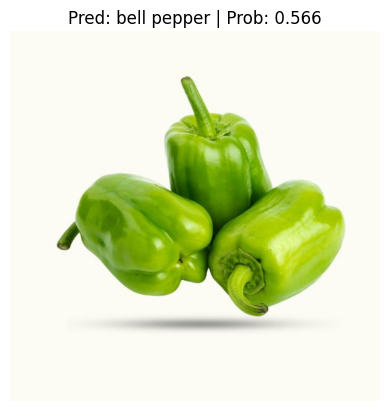

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test6.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

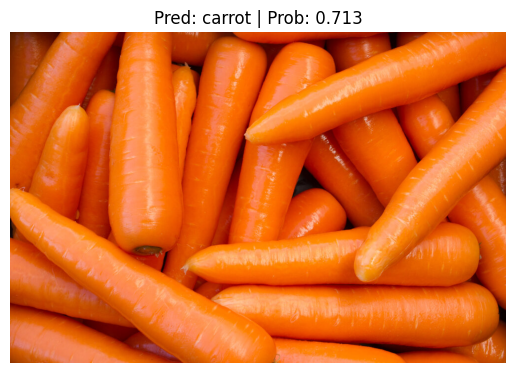

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test7.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

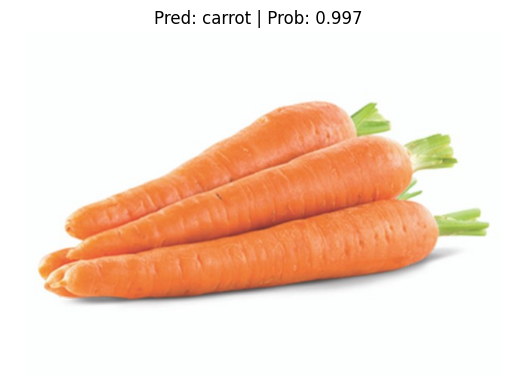

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test7_2.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

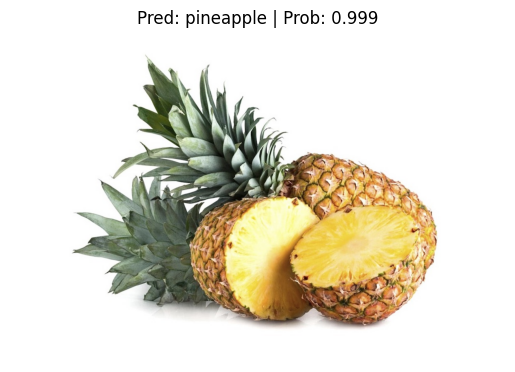

In [ ]:
custom_image_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Image_test8_2.jpg"

# Predict on custom image
pred_and_plot_image(model=model_loaded,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
val_dir = "/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/validation"
!ls "/content/drive/My Drive/Fruits_Vegetables_Data/archive (3)/validation"

[' apple\t        carrot\t\t garlic     lettuce   peas\t    spinach',
 ' banana         cauliflower\t ginger     mango     pineapple     sweetcorn',
 " beetroot      'chilli pepper'\t grapes     onion     pomegranate   sweetpotato",
 "'bell pepper'   corn\t\t jalepeno   orange    potato\t    tomato",
 ' cabbage        cucumber\t kiwi\t    paprika   raddish\t    turnip',
 " capsicum       eggplant\t lemon\t    pear     'soy beans'    watermelon"]

In [ ]:
train_data = datasets.ImageFolder(train_dir)

# Get class names
class_names = train_data.classes
class_names

['apple',
 'banana',
 'beetroot',
 'bell pepper',
 'cabbage',
 'capsicum',
 'carrot',
 'cauliflower',
 'chilli pepper',
 'corn',
 'cucumber',
 'eggplant',
 'garlic',
 'ginger',
 'grapes',
 'jalepeno',
 'kiwi',
 'lemon',
 'lettuce',
 'mango',
 'onion',
 'orange',
 'paprika',
 'pear',
 'peas',
 'pineapple',
 'pomegranate',
 'potato',
 'raddish',
 'soy beans',
 'spinach',
 'sweetcorn',
 'sweetpotato',
 'tomato',
 'turnip',
 'watermelon']

In [ ]:
image_transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                ),
            ]
        )
train_data = datasets.ImageFolder(train_dir, transform=image_transform)

# Get class names
class_names = train_data.classes
batch_size =128
val_data = datasets.ImageFolder(val_dir, transform=image_transform)
# Get class names
#class_names = val_data.classes

val_dataloader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
      )

In [ ]:
model_path = "/content/drive/My Drive/Fruits_Vegetables_Data/Models/Model_Vit_Final.pt"
model_loaded = torch.load(model_path)

In [ ]:
model=model_loaded
model.to(device)
model.eval()
val_loss = 0.0
correct = 0
total = 0
loss_fn = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    for inputs, targets in val_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        val_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

val_loss /= len(val_dataloader)
accuracy = correct / total

print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

Validation Loss: 0.2088, Validation Accuracy: 0.9345
